# Midiendo rendimiento y riesgo con datos históricos

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/7/7d/Copper_Price_History_USD.png" width="600px" height="400px" />

> Ya sabemos que podemos caracterizar la distribución de rendimientos de un activo mediante una medida de tendencia central (media: rendimiento esperado) y una medida de dispersión (desviación estándar: volatilidad). 

> En la clase pasada vimos como obtener reportes históricos de precios de activos. ¿Cómo usamos estos históricos para medir el rendimiento esperado y la volatilidad de los rendimientos?

*Objetivos:*
- Calcular los rendimientos a partir de históricos de precios.
- Estimar rendimiento esperado y riesgo a partir de históricos de rendimientos.
- Anualizar rendimiento y volatilidad cuando los datos están en una base de tiempo menor.
- Verificar la relación entre rendimiento y riesgo a través de datos reales.

**Referencias:**
- http://pandas.pydata.org/
- https://pandas-datareader.readthedocs.io/en/latest/
- Notas del curso "Portfolio Selection and Risk Management", Rice University, disponible en Coursera.
___

## 1. Cálculo de los rendimientos

Muy bien, ya entonces sabemos descargar históricos de precios...

**Ejemplo:** trabajaremos esta clase con activos que se encuentran en el top-50 del índice S&P500. Descargar precios ajustados en el cierre de Apple, Walmart, IBM y Nike desde el primero de enero del 2011 hasta el 31 de diciembre del 2015

In [14]:
# Importar paquetes
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import scipy.optimize as opt

In [15]:
help(web.YahooDailyReader)

Help on class YahooDailyReader in module pandas_datareader.yahoo.daily:

class YahooDailyReader(pandas_datareader.base._DailyBaseReader)
 |  YahooDailyReader(symbols=None, start=None, end=None, retry_count=3, pause=0.1, session=None, adjust_price=False, ret_index=False, chunksize=1, interval='d', get_actions=False, adjust_dividends=False)
 |  
 |  Returns DataFrame of with historical over date range,
 |  start to end.
 |  To avoid being penalized by Yahoo! Finance servers, pauses between
 |  downloading 'chunks' of symbols can be specified.
 |  
 |  Parameters
 |  ----------
 |  symbols : string, array-like object (list, tuple, Series), or DataFrame
 |      Single stock symbol (ticker), array-like object of symbols or
 |      DataFrame with index containing stock symbols.
 |  start : string, (defaults to '1/1/2010')
 |      Starting date, timestamp. Parses many different kind of date
 |      representations (e.g., 'JAN-01-2010', '1/1/10', 'Jan, 1, 1980')
 |  end : string, (defaults to 

In [46]:
# Función para descargar precios de cierre ajustados de varios activos a la vez:
def get_closes(tickers, start_date=None, end_date=None, freq=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Frecuencia de muestreo por defecto (freq='d')
    # Importamos paquetes necesarios
    import pandas as pd
    pd.core.common.is_list_like = pd.api.types.is_list_like
    import pandas_datareader.data as web  
    # Creamos DataFrame vacío de precios, con el índice de las fechas
    closes = pd.DataFrame(columns = tickers, index=web.YahooDailyReader(symbols=tickers[0], start=start_date, end=end_date, interval=freq).read().index)
    # Agregamos cada uno de los precios con YahooDailyReader
    for ticker in tickers:
        df = web.YahooDailyReader(symbols=ticker, start=start_date, end=end_date, interval=freq).read()
        closes[ticker]=df['Adj Close']
    closes.index_name = 'Date'
    closes = closes.sort_index()
    return closes

In [47]:
# Información
ticker= ['GMEXICOB.MX', 'GRUMAB.MX', 'ICHB.MX', 'IENOVA.MX', 'ICA']
start, end= '2016-01-01', '2019-03-01'


#### Como dijimos la clase pasada, la api de yahoo es inestable. Puede ser que nos toque intentar varias veces antes de tener éxito

In [48]:
# Precios diarios
daily_closes = get_closes(ticker, start, end, freq='d') #d define es diario
daily_closes

RemoteDataError: No data fetched for symbol ICA using YahooDailyReader

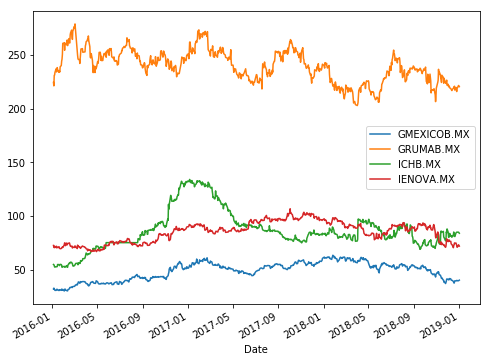

In [33]:
# Gráfico de histórico de precios diarios
daily_closes.plot(figsize=(8,6));

### 1.1. Rendimientos porcentuales

Muy bien, pero para el análisis no trabajamos con los precios sino con los rendimientos... **¿porqué?** 
Respuestas:
- Los rendimientos parecen conservar tendencias estadísticas constantes (p.e. oscilan alrededor de numeros cercanos a cero.)
- El valor esperado y la desviación es constante a través del tiempo, son estacionarias.

Para una sucesión de precios $\{S_t\}_{t=0}^{n}$, el rendimiento simple $R_t$ se define como el el cambio porcentual
$$
R_t=\frac{S_t-S_{t-1}}{S_{t-1}}
$$
para $t=1,\ldots,n$.

*¡Cuidado!* los rendimientos son de acuerdo a la base de tiempo en que se reportan los precios. Por ejemplo: 
- si los precios se reportan en una base diaria, los rendimientos también son diarios;
- si los precios se reportan en una base mensual, los rendimientos también son mensuales.

In [34]:
# Método shift() de un DataFrame...
help(pd.DataFrame.shift)

Help on function shift in module pandas.core.frame:

shift(self, periods=1, freq=None, axis=0)
    Shift index by desired number of periods with an optional time freq
    
    Parameters
    ----------
    periods : int
        Number of periods to move, can be positive or negative
    freq : DateOffset, timedelta, or time rule string, optional
        Increment to use from the tseries module or time rule (e.g. 'EOM').
        See Notes.
    axis : {0 or 'index', 1 or 'columns'}
    
    Notes
    -----
    If freq is specified then the index values are shifted but the data
    is not realigned. That is, use freq if you would like to extend the
    index when shifting and preserve the original data.
    
    Returns
    -------
    shifted : DataFrame



In [35]:
daily_closes

,GMEXICOB.MX,GRUMAB.MX,ICHB.MX,IENOVA.MX
Date,,,,
2016-01-04,32.227173,224.402893,54.930000,72.648369
2016-01-05,32.895004,221.242310,54.700001,71.155190
2016-01-06,32.100822,230.999359,53.970001,70.617638
2016-01-07,31.595440,231.265076,52.580002,71.981407
2016-01-08,30.828339,233.837234,52.570000,70.747040
2016-01-11,30.828339,237.083282,52.709999,71.394096
2016-01-12,31.667637,234.207397,52.830002,71.911728
2016-01-13,31.803009,235.621597,52.700001,70.358826
2016-01-14,31.803009,238.260208,52.939999,70.836639


In [36]:
daily_closes.shift()

,GMEXICOB.MX,GRUMAB.MX,ICHB.MX,IENOVA.MX
Date,,,,
2016-01-04,NaN,NaN,NaN,NaN
2016-01-05,32.227173,224.402893,54.930000,72.648369
2016-01-06,32.895004,221.242310,54.700001,71.155190
2016-01-07,32.100822,230.999359,53.970001,70.617638
2016-01-08,31.595440,231.265076,52.580002,71.981407
2016-01-11,30.828339,233.837234,52.570000,70.747040
2016-01-12,30.828339,237.083282,52.709999,71.394096
2016-01-13,31.667637,234.207397,52.830002,71.911728
2016-01-14,31.803009,235.621597,52.700001,70.358826


In [37]:
# Calcular los rendimientos
daily_ret = ((daily_closes-daily_closes.shift())/daily_closes.shift()).dropna()
daily_ret

,GMEXICOB.MX,GRUMAB.MX,ICHB.MX,IENOVA.MX
Date,,,,
2016-01-05,0.020723,-0.014084,-0.004187,-0.020554
2016-01-06,-0.024143,0.044101,-0.013346,-0.007555
2016-01-07,-0.015744,0.001150,-0.025755,0.019312
2016-01-08,-0.024279,0.011122,-0.000190,-0.017148
2016-01-11,0.000000,0.013882,0.002663,0.009146
2016-01-12,0.027225,-0.012130,0.002277,0.007250
2016-01-13,0.004275,0.006038,-0.002461,-0.021595
2016-01-14,0.000000,0.011199,0.004554,0.006791
2016-01-15,-0.020715,-0.006653,0.037023,0.001827


In [38]:
# Otra forma (más fácil)
daily_ret=daily_closes.pct_change().dropna()
daily_ret


,GMEXICOB.MX,GRUMAB.MX,ICHB.MX,IENOVA.MX
Date,,,,
2016-01-05,0.020723,-0.014084,-0.004187,-0.020554
2016-01-06,-0.024143,0.044101,-0.013346,-0.007555
2016-01-07,-0.015744,0.001150,-0.025755,0.019312
2016-01-08,-0.024279,0.011122,-0.000190,-0.017148
2016-01-11,0.000000,0.013882,0.002663,0.009146
2016-01-12,0.027225,-0.012130,0.002277,0.007250
2016-01-13,0.004275,0.006038,-0.002461,-0.021595
2016-01-14,0.000000,0.011199,0.004554,0.006791
2016-01-15,-0.020715,-0.006653,0.037023,0.001827


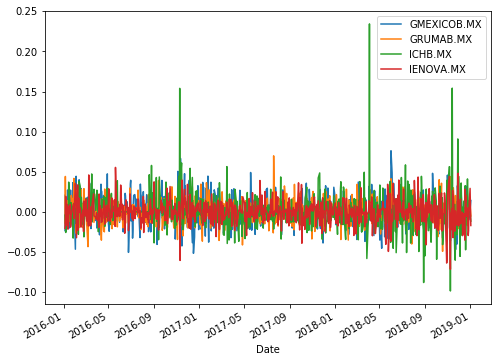

In [40]:
# Graficar...
daily_ret.plot(figsize=(8,6));

**¿Qué se observa respecto a los precios?**

Respuestas:
- Los rendimientos parecen conservar tendencias estadísticas constantes (p.e. oscilan alrededor de numeros cercanos a cero.)
- El valor esperado y la desviación es constante a través del tiempo, son estacionarias.

Típicamente se reportan rendimientos en una base anual. ¿Cómo los obtenemos? <font color=blue>(ver en el tablero)</font>

In [41]:
# Método groupby() de un DataFrame


In [42]:
# Crear una función que calcule rendimientos anuales a partir de rendimientos diarios
def calc_annual_ret(ret):
    return (1+ret).groupby(lambda date: date.year).prod()-1 #se suma 1 por ser rend 
                                                            #los hace "clusters" por año y los multiplica 
                                                            # entre ellos, luego -1 por la fórmula de series

In [43]:
# Calcular rendimientos anuales y mostrar
annual_ret = calc_annual_ret(daily_ret)
annual_ret

,GMEXICOB.MX,GRUMAB.MX,ICHB.MX,IENOVA.MX
2016,0.599722,0.117106,1.412161,0.239733
2017,0.175628,-0.036853,-0.366038,0.069183
2018,-0.343294,-0.082020,0.011786,-0.239113
2019,0.014095,-0.005164,-0.011648,-0.017060


### 1.2. Rendimientos logarítmicos (log-rendimientos)

Otro rendimiento usado con frecuencia es el rendimiento continuamente compuesto o rendimiento logaritmico. Éste, está definido como

$$
r_t=\ln\left(\frac{S_t}{S_{t-1}}\right).
$$

Es fácil darse cuenta que $r_t=\ln(1+R_t)$.

<font color=blue>Ver en el tablero</font> que si $0\leq|x|\ll 1$, entonces $\ln(1+x)\approx x$.

In [44]:
# Calcular rendimientos continuamente compuestos

daily_logret = np.log(daily_closes/daily_closes.shift()).dropna()
daily_logret

,GMEXICOB.MX,GRUMAB.MX,ICHB.MX,IENOVA.MX
Date,,,,
2016-01-05,0.020511,-0.014185,-0.004196,-0.020768
2016-01-06,-0.024439,0.043156,-0.013435,-0.007583
2016-01-07,-0.015869,0.001150,-0.026093,0.019128
2016-01-08,-0.024578,0.011061,-0.000190,-0.017297
2016-01-11,0.000000,0.013786,0.002660,0.009104
2016-01-12,0.026861,-0.012204,0.002274,0.007224
2016-01-13,0.004266,0.006020,-0.002464,-0.021831
2016-01-14,0.000000,0.011136,0.004544,0.006768
2016-01-15,-0.020933,-0.006675,0.036354,0.001825


In [45]:
# Recordar rendimientos porcentuales. Ver que son similares
daily_ret

,GMEXICOB.MX,GRUMAB.MX,ICHB.MX,IENOVA.MX
Date,,,,
2016-01-05,0.020723,-0.014084,-0.004187,-0.020554
2016-01-06,-0.024143,0.044101,-0.013346,-0.007555
2016-01-07,-0.015744,0.001150,-0.025755,0.019312
2016-01-08,-0.024279,0.011122,-0.000190,-0.017148
2016-01-11,0.000000,0.013882,0.002663,0.009146
2016-01-12,0.027225,-0.012130,0.002277,0.007250
2016-01-13,0.004275,0.006038,-0.002461,-0.021595
2016-01-14,0.000000,0.011199,0.004554,0.006791
2016-01-15,-0.020715,-0.006653,0.037023,0.001827


In [47]:
# Veamos el valor absoluto de la diferencia
np.abs(daily_ret-daily_logret)

,AAPL,WMT,IBM,NKE
Date,,,,
2011-01-04,1.357123e-05,7.387762e-06,5.880319e-07,3.082789e-04
2011-01-05,3.327481e-05,2.169675e-05,8.005323e-06,2.135778e-05
2011-01-06,3.267672e-07,3.439031e-05,5.949980e-05,4.067118e-05
2011-01-07,2.552142e-05,2.468685e-06,1.209491e-05,3.778218e-06
2011-01-10,1.751341e-04,2.103302e-05,1.924535e-06,2.920782e-05
2011-01-11,2.801695e-06,5.394264e-05,2.976198e-06,1.589931e-06
2011-01-12,3.292676e-05,5.283491e-05,7.572498e-05,5.971537e-06
2011-01-13,6.677172e-06,5.987245e-07,1.765252e-06,9.854273e-05
2011-01-14,3.262660e-05,6.661131e-08,3.126848e-05,1.652467e-04


Por lo anterior, muchas veces se usan para el análisis los rendimientos continuamente compuestos.
___

## 2. Caracterización de la distribución de los rendimientos

Entonces:
- partimos de que tenemos los rendimientos porcentuales diarios de Apple, Walmart, IBM y Nike desde inicios del 2011 a finales del 2015;
- ¿cómo resumirían estos datos?

In [48]:
# Rendimiento medio diario (media aritmética) -suponiendo igual probabilidad-
daily_ret.mean()

AAPL    0.001062
WMT     0.000246
IBM     0.000112
NKE     0.001117
dtype: float64

In [49]:
# Volatilidad diaria (desviación estándar)
daily_ret.std()

AAPL    0.016996
WMT     0.010152
IBM     0.012133
NKE     0.015056
dtype: float64

In [51]:
# Podemos resumir en un DataFrame
daily_ret_summary = pd.DataFrame(index= ['Mean', 'Volatility'], columns=ticker)
daily_ret_summary.loc['Mean']= daily_ret.mean()
daily_ret_summary.loc['Volatility']= daily_ret.std()
daily_ret_summary

,AAPL,WMT,IBM,NKE
Mean,0.00106192,0.000246175,0.000111607,0.00111744
Volatility,0.0169958,0.0101519,0.0121334,0.0150561


Normalmente se reportan rendimientos esperados y volatilidades en una base anual. Para anualizar:

$$E[r_a]=12E[r_m]=252E[r_d]=52E[r_w],\text{ y}$$

$$\sigma_{r_a}=\sqrt{12}\sigma_{r_m}=\sqrt{252}\sigma_{r_d}=\sqrt{52}\sigma_{r_w}$$

In [52]:
# Resumen en base anual
annual_ret_summary = pd.DataFrame(index= ['Mean', 'Volatility'], columns=ticker)
annual_ret_summary.loc['Mean']= daily_ret.mean()*252 #cambias la media diaria (Esperada) por 252 para anualizar
annual_ret_summary.loc['Volatility']= daily_ret.std()*np.sqrt(252) 
annual_ret_summary

,AAPL,WMT,IBM,NKE
Mean,0.267604,0.062036,0.028125,0.281595
Volatility,0.2698,0.161156,0.192611,0.239008


In [54]:
annual_ret_summary.loc['Volatility'].values #muestra las volatilidades

array([0.2698004868794504, 0.1611562171433023, 0.19261145347510022,
       0.2390083283321651], dtype=object)

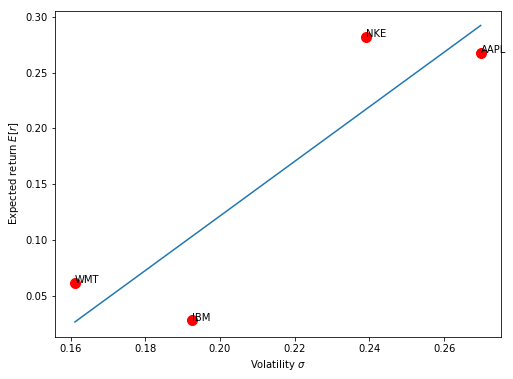

In [85]:
# Gráfico rendimiento esperado vs. volatilidad
# Puntos a graficar
x_points = annual_ret_summary.loc['Volatility'].values
y_points = annual_ret_summary.loc['Mean'].values
#Ventana para graficar
plt.figure(figsize=(8,6))
# Graficar puntos
plt.plot(x_points, y_points, 'ro', ms=10)
# Etiqueta de los ejes
plt.xlabel('Volatility $\sigma$')
plt.ylabel('Expected return $E[r]$')
# Etiqueta de cada instrumento
plt.text(x_points[0],y_points[0],ticker[0])
plt.text(x_points[1],y_points[1],ticker[1])
plt.text(x_points[2],y_points[2],ticker[2])
plt.text(x_points[3],y_points[3],ticker[3])
#Grafica recta ajustada
plt.plot(np.sort(x_points), res.x[0]+res.x[1]*np.sort(x_points)) #np.sort acomoda los datos

**¿Qué se puede concluir acerca de la relación entre riesgo (medido con la volatilidad) y el rendimiento esperado (medido con la media)?**
Respuestas:
- Para un rendimiento mas alto, se necesita asumir un riesgo mayor. 
- La relacion entre rendimiento esperado y riesgo es positiva (de acuerdo a los datos).
___

### 2.1 Ajuste de curvas con mínimos cuadrados
Consideramos que tenemos un conjunto de n pares ordenados de datos $(\sigma{r_i},E[r_i])$, para $i=1,2,3,\dots,n$... **en este caso corresponden a volatilidad y rendimiento esperado**

#### ¿Cuál es la recta que mejor se ajusta a estos datos?
Consideramos entonces ajustes de la forma $\hat{f}(\sigma) = \beta_0+\beta_1 \sigma = \left[1 \quad \sigma\right]\left[\begin{array}{c} \beta_0 \\ \beta_1 \end{array}\right]=\left[1 \quad \sigma\right]\boldsymbol{\beta}$ (lineas rectas).

Para decir '*mejor*', tenemos que definir algún sentido en que una recta se ajuste *mejor* que otra.

**Mínimos cuadrados**: el objetivo es seleccionar los coeficientes $\boldsymbol{\beta}=\left[\beta_0 \quad \beta_1 \right]^T$, de forma que la función evaluada en los puntos $\sigma_{r_i}$ ($\hat{f}(\sigma_{r_i})$) aproxime los valores correspondientes $E[r_i]$.

La formulación por mínimos cuadrados, encuentra los $\boldsymbol{\beta}=\left[\beta_0 \quad \beta_1 \right]^T$ que minimiza
$$\sum_{i=1}^{n}(E[r_i]-\hat{f}(\sigma_{r_i}))^2$$

In [ ]:
# Importamos scipy.optimize

In [68]:
# Funcion minimize
help(opt.minimize)

Help on function minimize in module scipy.optimize._minimize:

minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
    Minimization of scalar function of one or more variables.
    
    In general, the optimization problems are of the form::
    
        minimize f(x) subject to
    
        g_i(x) >= 0,  i = 1,...,m
        h_j(x)  = 0,  j = 1,...,p
    
    where x is a vector of one or more variables.
    ``g_i(x)`` are the inequality constraints.
    ``h_j(x)`` are the equality constrains.
    
    Optionally, the lower and upper bounds for each element in x can also be
    specified using the `bounds` argument.
    
    Parameters
    ----------
    fun : callable
        Objective function.
    x0 : ndarray
        Initial guess.
    args : tuple, optional
        Extra arguments passed to the objective function and its
        derivatives (Jacobian, Hessian).
    method : str or callable, op

In [81]:
# Funcion objetivo y condicion inicial
def fun_obj(b,x,y): #siendo y el E(ri) y x como f(sigma de ri)
    return np.sum((y - b[0]-b[1]*x)**2) #x es sigma

b0=[0,0] #filler inicial para la funcion opt.minimize

In [83]:
# Resolver problema de optimizacion
res = opt.minimize(fun_obj, b0, args=(x_points, y_points)) #optimiza la funcion objetivo evaluada en x^ y y^ points
res

      fun: 0.011724109202060622
 hess_inv: array([[  3.45045893, -15.44613463],
       [-15.44613463,  71.64769945]])
      jac: array([  1.59279443e-06,   3.40747647e-07])
  message: 'Optimization terminated successfully.'
     nfev: 52
      nit: 11
     njev: 13
   status: 0
  success: True
        x: array([-0.36685072,  2.44240757])

In [1]:
# Gráfico rendimiento esperado vs. volatilidad, y ajuste
# Puntos a graficar
x_points = annual_ret_summary.loc['Volatility'].values
y_points = annual_ret_summary.loc['Mean'].values
# Ventana para graficar
plt.figure(figsize=(8,6))
# Graficar puntos
plt.plot(x_points,y_points,'ro',ms=10)
# Etiquetas de los ejes
plt.xlabel('Volatility $\sigma$')
plt.ylabel('Expected return $E[r]$')
# Etiqueta de cada instrumento
plt.text(x_points[0],y_points[0],names[0])
plt.text(x_points[1],y_points[1],names[1])
plt.text(x_points[2],y_points[2],names[2])
plt.text(x_points[3],y_points[3],names[3])
# Grafico recta ajustada
plt.plot(np.sort(x_points),res.x[0]+res.x[1]*np.sort(x_points))

NameError: name 'annual_ret_summary' is not defined

## 3. Comentarios finales acerca del uso de datos históricos.

### ¡Cuidado!
- Es cierto que los patrones que vemos sobre periodos largos de tiempo en diferentes tipos de intrumentos son muy robustos en términos de la relación rendimiento/riesgo (positiva).
- Por tanto, esperamos rendimientos más altos en el futuro cuando asumimos cierto riesgo.
- ¿Cómo encontramos ese 'rendimiento esperado' en el futuro'? Datos históricos (humanos: tendencia a generalizar)

- Entonces, la idea es que si los rendimientos esperados son un p.e. estacionario, el promedio de muchos rendimientos pasados es una buena estimación del rendimiento esperado futuro (Teorema del límite central).
- ¿Deberíamos pensarlo dos veces?

## SI

Problemas:
- La muestra de datos en el periodo específico de tiempo puede estar sesgada.
- Ventanas de tiempo más grandes reducen especificidad de la muestra y estimados más precisos.
 - Aún así, datos muy viejos pueden ser no representativos.
- Nuevos fondos o estrategias de inversión están a menudo sesgados positivamente:
 - reporte de resultados en tiempos voluntarios;
 - las que mueren (no funcionan), no se reportan;

# Anuncios parroquiales:
## 1. Fin Módulo 1. Revisar que se hayan cumplido los objetivos del módulo (Clase0)
## 2. Tarea: revisar archivo "Tarea3_MidiendoRendimientoRiesgo" en clase.
## 3. Recordar quiz la siguiente clase.
## 4. Para hoy en la noche tengo realimentación de las tareas de github colaborativo. Segunda entrega para el miércoles 5 de septiembre.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>